In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import time
from datetime import timedelta

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2 anndata==0.6.4 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.0 


This notebook is a companion to the original pancreas BBKNN notebook, evaluating the performance of mnnCorrect on the same data. A lot of callbacks are made to the original notebook's analysis and conclusions, so take a look at that one first.

We created `.h5ad` exports of all the major structures in the BBKNN notebook, so let's make use of them to recreate the data at a stage that is appropriate to feed to the two other methods - 10,000 total counts per cell, then filtered to highly variable genes (with parameter values from the original notebook), then log-transformed.

In [2]:
adata = sc.read('objects-pancreas/pancreas.h5ad')
adata = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=2.5, min_disp=0.7)
adata = adata[:, filter_result.gene_subset]
sc.pp.log1p(adata)

Let's begin with mnnpy, a third party Python implementation of mnnCorrect that's now integrated into scanpy. Keep track of runtime, being mindful of BBKNN taking 3-6 seconds (depending on the selected options).

In [3]:
t1 = time.time()
corrected = sc.pp.mnn_correct(adata[adata.obs['sample']=='Baron'],adata[adata.obs['sample']=='Muraro'],
                             adata[adata.obs['sample']=='Segerstolpe'],adata[adata.obs['sample']=='Wang'])
t2 = time.time()
print('Took '+str(timedelta(seconds=t2-t1)))

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 3: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 3: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 3: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.
Took 0:19:03.181595


Run the mnnpy-corrected data through the rest of the analysis pipeline established in the original notebook. Notice how the UMAP is still quite fragmented by batch, and the cell types don't have a chance to be reunited (like in the BBKNN plots).

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:08.71) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.35) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.81) --> found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
... storing 'celltype' as categorical
... storing 'sample' as categorical


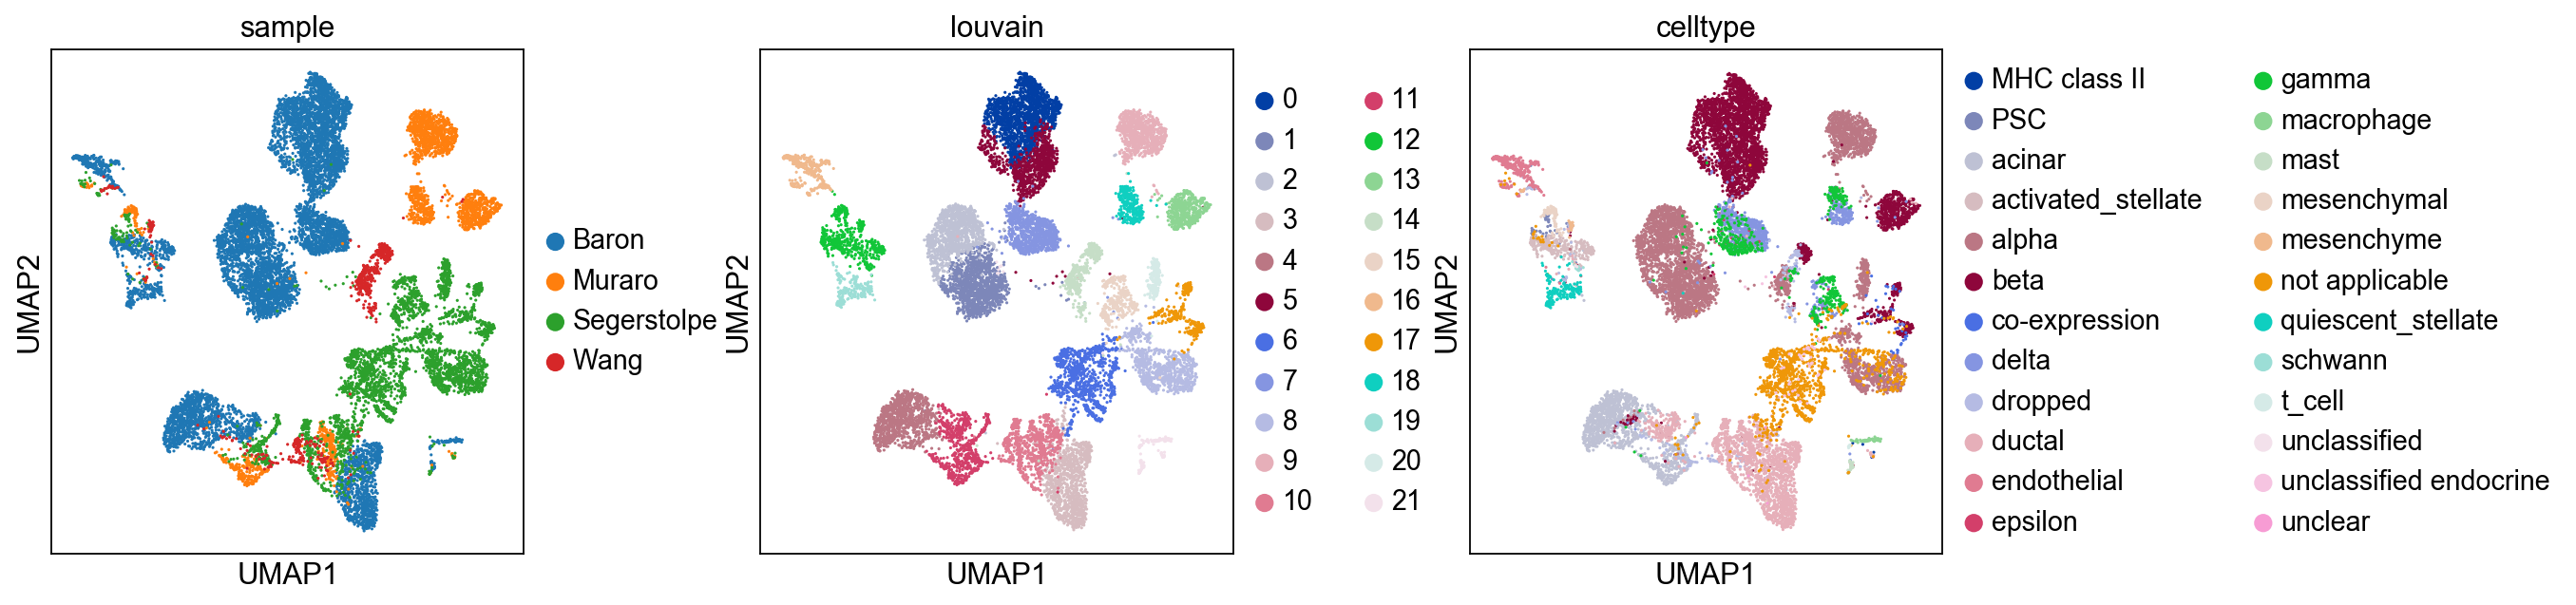

In [4]:
adata_mnnpy = corrected[0]
sc.pp.scale(adata_mnnpy, max_value=10)
sc.tl.pca(adata_mnnpy)
adata_mnnpy.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pp.neighbors(adata_mnnpy,n_pcs=20, n_neighbors=20)
sc.tl.umap(adata_mnnpy)
sc.tl.louvain(adata_mnnpy)
sc.pl.umap(adata_mnnpy, color=['sample','louvain','celltype'])

Run the original, just in case. But before we can do that, we need to load up Rmagic again and ensure that we have scran set up. This can be a bit of a dependency adventure, and if you've got your setup running through conda you may have to call `conda install -c r r-xml` to set up XML correctly for biomaRt (a dependency of scran) to use.

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R

if (!('scran' %in% rownames(installed.packages())))
{
    source("https://bioconductor.org/biocLite.R")
    biocLite("scran")
}

Prepare the data for R consumption - create data frames for each of the samples.

In [7]:
df1 = pd.DataFrame(data=adata[adata.obs['sample']=='Baron'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Baron'].var_names,
                  columns=adata[adata.obs['sample']=='Baron'].obs_names)

df2 = pd.DataFrame(data=adata[adata.obs['sample']=='Muraro'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Muraro'].var_names,
                  columns=adata[adata.obs['sample']=='Muraro'].obs_names)

df3 = pd.DataFrame(data=adata[adata.obs['sample']=='Segerstolpe'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Segerstolpe'].var_names,
                  columns=adata[adata.obs['sample']=='Segerstolpe'].obs_names)

df4 = pd.DataFrame(data=adata[adata.obs['sample']=='Wang'].X.todense().transpose(),
                  index=adata[adata.obs['sample']=='Wang'].var_names,
                  columns=adata[adata.obs['sample']=='Wang'].obs_names)

With that, we good for one go of the original mnnCorrect. As usual, time it. The run time is similar to the Python implementation.

In [8]:
%%R -i df1 -i df2 -i df3 -i df4 -o odf1 -o odf2 -o odf3 -o odf4

suppressMessages(library(scran))

t1 = Sys.time()
mnncount = mnnCorrect(data.matrix(df1), data.matrix(df2), data.matrix(df3), data.matrix(df4), 
                      BPPARAM=MulticoreParam(detectCores()))
t2 = Sys.time()
print(t2-t1)

odf1 = data.frame(mnncount$corrected[[1]])
odf2 = data.frame(mnncount$corrected[[2]])
odf3 = data.frame(mnncount$corrected[[3]])
odf4 = data.frame(mnncount$corrected[[4]])

Time difference of 15.2156 mins


Fire up the standard analysis plus UMAP visualisation part of the deal again. Notice how the plots look a little better than mnnpy, but it's not a major difference.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:05.73) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:10.33) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.78) --> found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


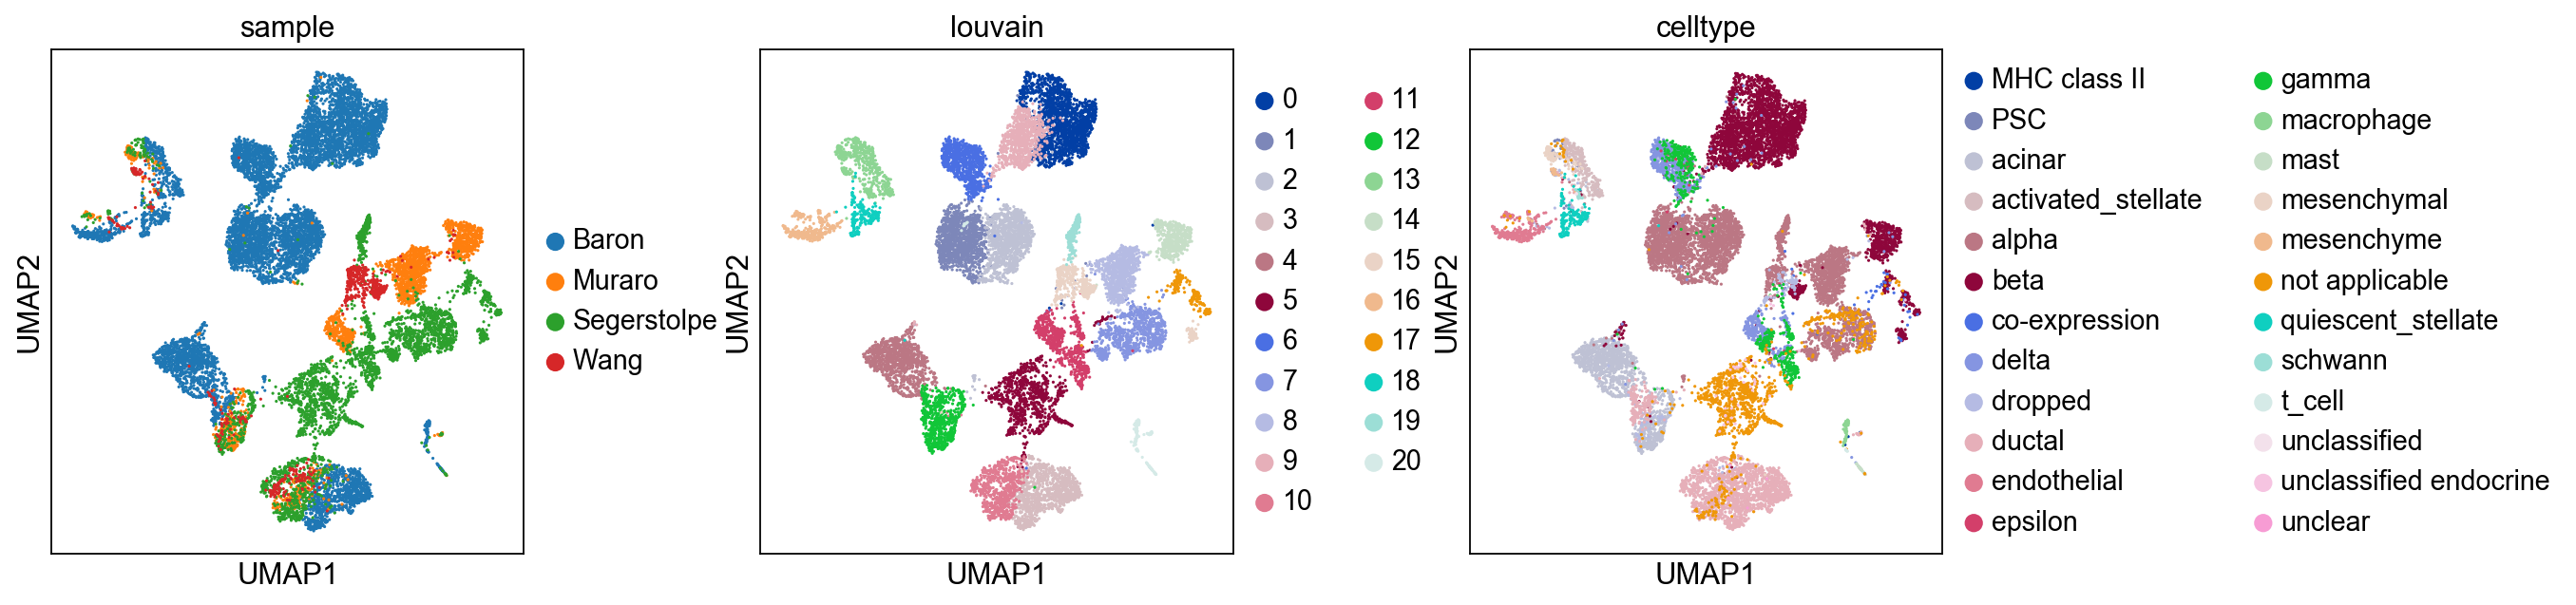

In [9]:
adata_mnncorrect = adata.copy()
adata_mnncorrect.X = np.concatenate((odf1.values.T, odf2.values.T, odf3.values.T, odf4.values.T))
sc.pp.scale(adata_mnncorrect, max_value=10)
sc.tl.pca(adata_mnncorrect)
adata_mnncorrect.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pp.neighbors(adata_mnncorrect,n_pcs=20, n_neighbors=20)
sc.tl.umap(adata_mnncorrect)
sc.tl.louvain(adata_mnncorrect)
sc.pl.umap(adata_mnncorrect, color=['sample','louvain','celltype'])

Stay tuned for a third notebook in which we run CCA, as R's DLL limit makes loading Seurat and scran simultaneously impossible. For now let's do the standard thing of saving the objects.

In [10]:
adata_mnnpy.write('objects-pancreas/pancreas_mnnpy.h5ad')
adata_mnncorrect.write('objects-pancreas/pancreas_mnncorrect.h5ad')